<a href="https://colab.research.google.com/github/nipunikajain/DeepLearning1/blob/main/02_Neural_Network_Classification_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### What are we going to cover
1. Architecture of a NN classification model
2. Inout shapes and output shapes of a classification model (features and labels)
3. Creating custom data to view, fit on and predict on
4. Steps in modelling
  - Creating a model, setting a loss function and optimiser, creating a training loop and evaluating a model
5. Saving and loading models
6. Harnessing the power of non-linearity
7. Different classification evaluation methods

# 02. NN classification with PyTorch
Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options).


Book version for PyTorch course: https://www.learnpytorch.io/02_pytorch_classification/


## 1. Make classification data and get it ready

In [2]:
import sklearn
import torch

In [3]:
from sklearn.datasets import make_circles

# Make 1000 samples

n_samples = 1000

# Create circles
X,y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

In [4]:
len(X), len(y)

(1000, 1000)

In [5]:
print("First 5 samples of X \n", X[:5])
print("First 5 samples of y \n", y[:5])

First 5 samples of X 
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y 
 [1 1 1 1 0]


In [6]:
# Make dataframe of circle data
import pandas as pd

circles = pd.DataFrame({"X1" : X[:,0],
                        "X2" : X[:,1],
                       "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [7]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

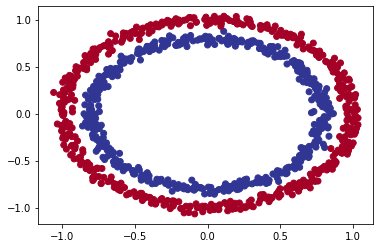

In [8]:
# Visualize
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],
            y = X[:,1],
            c=y,
            cmap = plt.cm.RdYlBu);

Note: The data we're working with is often referred to as a Toy dataset, which is small enough to experiment on but still sizeable to enough to practive the fundamentals

### 1.1 Check input and output shapes

In [9]:
print("Shape of X is:", X.shape)
print("Shape of y is:", y.shape)

Shape of X is: (1000, 2)
Shape of y is: (1000,)


In [10]:
# View the first example of features and labels

X_sample=X[0]
y_sample = y[0]

print("Values for one sample of X:", X_sample, "and shape:", X_sample.shape)
print("Values for one sample of y:", y_sample, "and shape:", y_sample.shape)


Values for one sample of X: [0.75424625 0.23148074] and shape: (2,)
Values for one sample of y: 1 and shape: ()


### 1.2 Turn data into tensors and create train and test splits

In [11]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]), tensor([1., 1., 1., 1., 0.]))

In [12]:
# Train Test split

from sklearn.model_selection import train_test_split

X_train, X_test ,  y_train, y_test = train_test_split(X,
                                                      y,
                                                      test_size=0.2, # 20% of data will be test
                                                      random_state=42)



In [13]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code, so our code will run on an accelerator (GPU) if there is of
2. Construct a model (subclassing `nn.Module`)
3. Define loss function and optimizer
4. Create training and test loop

In [14]:
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Now, let's create a model that:
1. Subclasses `nn.Module` ( almost all models in Pytorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling shapes of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computaiton) of the model_selection
4. Instantiate an instance of our model class and send it to the target device

In [15]:
# 1. Construct a model that subclasses nn.Module

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features= 2, out_features = 5) # takes in 2 features and upscales to 5 features
    self.layer_2 = nn.Linear(in_features= 5, out_features = 1) # takes in 5 features from previous layer and output a single feature (same shape as y)

  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4. Instantiate an instance of our model class and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
device

'cuda'

In [17]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [18]:
# Let's replicate themodel above using nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
model_0.state_dict()

OrderedDict([('0.weight', tensor([[ 0.4418, -0.5525],
                      [ 0.1996, -0.4485],
                      [ 0.2612, -0.1490],
                      [-0.6848, -0.2915],
                      [-0.4215, -0.3661]], device='cuda:0')),
             ('0.bias',
              tensor([-0.0098, -0.3983, -0.5199,  0.5779,  0.6487], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.3552, -0.2999, -0.1481, -0.0704,  0.1221]], device='cuda:0')),
             ('1.bias', tensor([0.1881], device='cuda:0'))])

In [20]:
# make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print("Length of predictions", len(untrained_preds))
print("Shape of predictions", untrained_preds.shape)
print("Length of test samples", len(X_test))
print("Shape of test samples", X_test.shape)
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")


Length of predictions 200
Shape of predictions torch.Size([200, 1])
Length of test samples 200
Shape of test samples torch.Size([200, 2])

First 10 predictions:
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [21]:
X_test[:10], y_test[:10], 

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use

Again... this is problem specific..

For example for Regression you might want MAE or MSE

For classification you might want binary cross entropy or categorical cross entropy (cross entropy)

As a reminder, the loss function measures how wrong your model's predictions are.

And for optimizers two of the most common and useful are SGD and ADAM, although PyTorch has other optimizers as well.

* For the loss function we're going to use `torch.nn.BCEWithLogitLoss()`
* For different optimizers see `torch.optim`

In [22]:
 # Setup the loss function
# loss_fn = nn.BCELoss() # requires inputs to have gone through the sigmiod activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # this has sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.1)


In [23]:
# Calculate accuracy - out of 100 examples what % does our model get right?

def accuracy_fn(y_true,y_pred): 
  correct = torch.eq(y_true,y_pred).sum().item()    
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train Model

To train our model, we're going to build a training loop:
1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Back prop (loss backward)
5. Optimizer (gradiet descent)

### 3.1 Going from raw logits -> Prediction probabilities -> prediction labels
Our model outputs are going to be raw *logits*

We can convert these **logits** into prediction probabilities by passing them into some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification)

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the argmax()

In [24]:
# View the first 5 outputs of forward pass on the test data

model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits # the output below is in the form of logic which is like a raw output which needs to be further fed to an activation function

tensor([[0.3553],
        [0.3591],
        [0.4009],
        [0.3422],
        [0.4892]], device='cuda:0')

In [25]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [26]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities

y_pred_probs = torch.sigmoid(y_logits)

y_pred_probs

tensor([[0.5879],
        [0.5888],
        [0.5989],
        [0.5847],
        [0.6199]], device='cuda:0')

For our prediction probabilities values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` (class=1)
* `y_pred_probs` < 0, `y=0` (class=0)

In [27]:
# Find the predicted labels 

y_preds = torch.round(y_pred_probs)

# in full ( logits -> pred probs -> pred_labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension

y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0')

In [28]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a training and test loop

In [29]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# an epoch is one loop through the data
epochs = 1000

# Put data to target device

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


# Track different values
epoch_count= []
loss_values= []
test_loss_values= []

### Training
# 0. Loop through the data
for epoch in range(epochs):
  # set the model to training model
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate the loss/accuracy

  # loss = loss_fn(torch.sigmoid(y_logits), # if loss was nn.BCELoss, it expects prediction probabilities as input
  #                y_train)

  loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects logits as input
                 y_train)
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)

  # 3. Optimizer zero grad - zero the optimizer gradients ( they accumulate every epoch, zero them to start fresh each forward pass )
  optimizer.zero_grad()

  # 4. Perform backprop on the loss w.r.t. the parameters of the model
  loss.backward()

  # 5. Step the optimizer ( perform gradient descent)
  optimizer.step()

  ### Testing

  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate the test loss/ accuracy
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred= test_pred)
    
  # Print out what's happenin'
  if epoch %10 == 0:
    print(f"Epoch:{epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss:{test_loss:.5f}, Test acc: {test_acc:.2f}%")




Epoch:0 | Loss: 0.71566, Acc: 50.00 | Test loss:0.71186, Test acc: 50.00%
Epoch:10 | Loss: 0.70053, Acc: 50.00 | Test loss:0.70019, Test acc: 50.00%
Epoch:20 | Loss: 0.69626, Acc: 57.50 | Test loss:0.69722, Test acc: 57.00%
Epoch:30 | Loss: 0.69491, Acc: 53.00 | Test loss:0.69644, Test acc: 51.50%
Epoch:40 | Loss: 0.69439, Acc: 51.88 | Test loss:0.69619, Test acc: 50.50%
Epoch:50 | Loss: 0.69411, Acc: 51.12 | Test loss:0.69606, Test acc: 51.50%
Epoch:60 | Loss: 0.69392, Acc: 50.88 | Test loss:0.69596, Test acc: 51.00%
Epoch:70 | Loss: 0.69378, Acc: 50.75 | Test loss:0.69587, Test acc: 50.00%
Epoch:80 | Loss: 0.69366, Acc: 51.12 | Test loss:0.69579, Test acc: 49.50%
Epoch:90 | Loss: 0.69356, Acc: 51.12 | Test loss:0.69571, Test acc: 48.50%
Epoch:100 | Loss: 0.69347, Acc: 51.00 | Test loss:0.69564, Test acc: 48.50%
Epoch:110 | Loss: 0.69340, Acc: 51.00 | Test loss:0.69558, Test acc: 48.00%
Epoch:120 | Loss: 0.69334, Acc: 51.75 | Test loss:0.69553, Test acc: 48.00%
Epoch:130 | Loss: 0.693

 ## 4. Make predictions and evaluate the model

 From the metrics it looks like our model isin't learning anything...

 So to inspect it let's make some prections and make them visual

 To do so, we're going to import a function called `plot_decision_boundary()` - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [30]:
# import requests
# from pathlib import Path

# # Download helper functions from Lear PyTorch repo ( if it's not already downloaded)

# if Path("helper_functions.py").is_file():
#   print("helper_functions.py already exists, skipping download")
# else:
#   print("Downloading helper_functions.py")
#   request = requests.get(url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  
#   with open("helper_functions.py","wb") as f:
#     f.write(request.content)



In [31]:
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py


from helper_functions import plot_predictions, plot_decision_boundary



--2023-03-15 00:11:59--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10160 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.92K  --.-KB/s    in 0s      

2023-03-15 00:12:00 (102 MB/s) - ‘helper_functions.py’ saved [10160/10160]



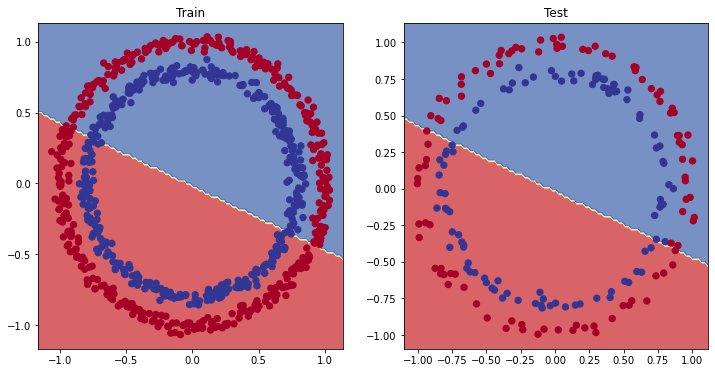

In [32]:
# plot decisio0n boundary of the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)

## 5. Improving a model ( from a model perspective )

* Add more layers - give the model more chances to learn about patterns in the data

* Add more hidden units - go from 5 hidden units to 10 hidden units

* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from a model's perspective because they deal directly with model and not with the data

And because these options are all values we can change, they are referred to as **Hyperparameters**

Let's try and improve our model by:
* Adding more hidden units: 5->10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [35]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features=10)
    self.layer_2 = nn.Linear(in_features = 10, out_features=10)
    self.layer_3 = nn.Linear(in_features = 10, out_features=1)
  
  def forward(self,x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations leverages speed ups where possible

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [33]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer

optimizer = torch.optim.SGD(params=model_1.parameters(),lr = 0.001)

In [33]:
# Write training and evaluation loop for model_1

epochs_1 = 100

for epoch in range(epochs):
  model_1.train()

# forward pass
  y_logits1 = model_1(X_train).squeeze()
  y_pred1 = torch.round(torch.sigmoid(y_logits1))

